# Training a dense neural network

### Let's focus on the problem of handwritten digit recognition. It is a classification problem, because 
### for each input image we need to specify the class - which digit it is.

### In this unit, we start with the simplest possible approach for image classification - 
### a fully-connected neural network (which is also called a perceptron). We will recap the way neural 
### networks are defined in PyTorch, and how the training algorithm works. If you are familiar with those 
### concepts - feel free to skip to the next unit, where we introduce Convolutional Neural Networks (CNNs).

### We use pytorchcv helper to load all data we have talked about in the previous unit.

In [1]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2022-06-22 16:51:37--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.22K  --.-KB/s    in 0.001s  

2022-06-22 16:51:40 (4.57 MB/s) - ‘pytorchcv.py’ saved [6371/6371]



In [3]:
!pip install torchinfo

In [4]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary

from pytorchcv import load_mnist, plot_results
load_mnist()

# Fully-connected dense neural networks
### A basic neural network in PyTorch consists of a number of layers. The simplest network would include 
### just one fully-connected layer, which is called Linear layer, with 784 inputs (one input for each pixel of 
### the input image) and 10 outputs (one output for each class).

### In PyTorch, we often prefer to use LogSoftmax function, which will also compute logarithms of output 
### probabilities. To turn the output vector into the actual probabilities, we need to take torch.exp of the
### output.

In [5]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

# Training the network
### A network defined in this way can take any digit as input and produce a vector of probabilities as an 
### output. Let's see how this network performs by giving it a digit from our dataset:

In [6]:
print('Digit to be predicted: ',data_train[0][1])
torch.exp(net(data_train[0][0]))

Digit to be predicted:  5


/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.0980, 0.1075, 0.1034, 0.1127, 0.0736, 0.1085, 0.1105, 0.0922, 0.1159,
         0.0776]], grad_fn=<ExpBackward0>)

### Because we use LogSoftmax as final activation of our network, we pass network output through torch.exp 
### to get probabilities.

### As you can see the network predicts similar probabilities for each digit. This is because it has not been 
### trained on how to recognize the digits. We need to give it our training data to train it on our dataset.

### To train the model we will need to create batches from our dataset of a certain size, let's say 64. 
### PyTorch has an object called DataLoader that can create batches of our data for us automatically:

In [7]:
train_loader = torch.utils.data.DataLoader(data_train,batch_size=64)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=64) # we can use larger batch size for testing

In [8]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net,train_loader)

(0.005934380594889323, 0.89285)

In [9]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.005858503723144531, 0.893)

### Similarly to train function, we return average loss and accuracy on test dataset.

# Overfitting
### Normally when training a neural network, we train the model for several epochs observing training and 
### validation accuracy. In the beginning, both training and validation accuracy should increase, as the 
### network picks up the patterns in the dataset. However, at some point it can happen that training accuracy 
### increases while validation accuracy starts to decrease. That would be an indication of overfitting, 
### that is model does well on your training dataset, but not on new data.

### Below is the training function that can be used to perform both training and validation. 
### It prints the training and validation accuracy for each epoch, and also returns the history that can be 
### used to plot the loss and accuracy on the graph.

In [10]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.893, Val acc=0.893, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.897, Train loss=0.005, Val loss=0.006


### This function logs messages with the accuracy on training and validation data from each epoch. 
### It also returns this data as a dictionary (called history). We can then visualize this data to better
### understand our model training.



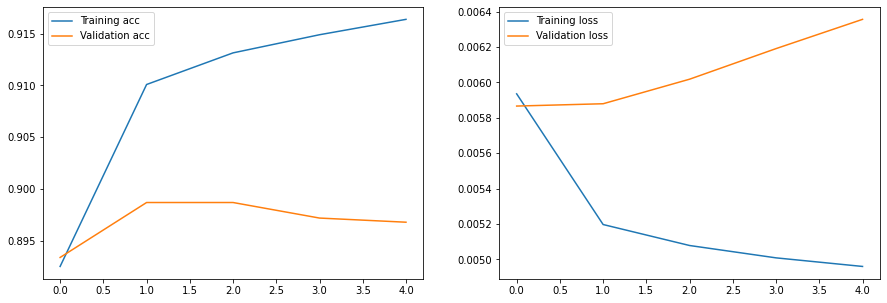

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()


# Visualizing network weights

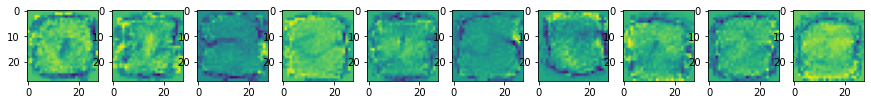

In [12]:
weight_tensor = next(net.parameters())
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach())

# Multi-layered perceptron

In [13]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,100),     # 784 inputs, 100 outputs
        nn.ReLU(),              # Activation Function
        nn.Linear(100,10),      # 100 inputs, 10 outputs
        nn.LogSoftmax(dim=0))

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─LogSoftmax: 1-5                        [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

## There is another syntax that we can use to define the same network by using classes:

In [14]:
from torch.nn.functional import relu, log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x,dim=0)
        return x

net = MyNet()

summary(net,input_size=(1,28,28),device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

## train this network

Epoch  0, Train acc=0.927, Val acc=0.946, Train loss=0.035, Val loss=0.034
Epoch  1, Train acc=0.953, Val acc=0.956, Train loss=0.033, Val loss=0.033
Epoch  2, Train acc=0.957, Val acc=0.958, Train loss=0.033, Val loss=0.033
Epoch  3, Train acc=0.961, Val acc=0.955, Train loss=0.033, Val loss=0.033
Epoch  4, Train acc=0.962, Val acc=0.960, Train loss=0.033, Val loss=0.033


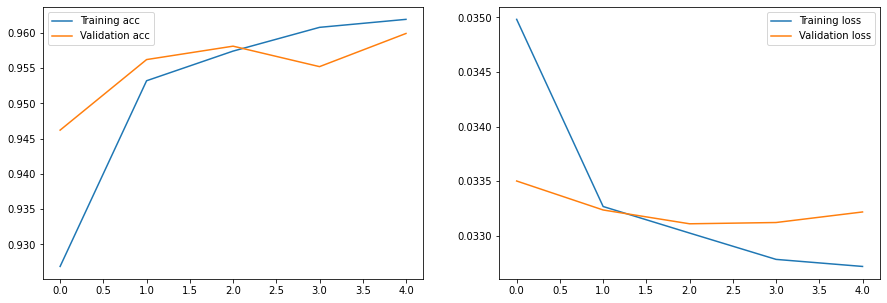

In [16]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)